In [7]:
%load_ext autoreload
%autoreload 2

from rmrl.experiments.configurations import *
from rmrl.experiments.with_transfer import WithTransferExperiment
from rmrl.experiments.experiment import EXPERIMENTS_DUMPS_DIR
from rmrl.experiments.experiment import Experiment
from rmrl.experiments.runner import ExperimentsRunner
from rmrl.experiments.vis import Plotter
from pathlib import Path


import matplotlib.pyplot as plt
from itertools import product
from tqdm.auto import tqdm





The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


{ 1: 'env-small/cspace-fixed_entities/alg-PPO/mods-(AS,RS)/rm_kwargs-((goal_state_reward-1.0),(grid_resolution-(2,2)),(fuel_resolution-1))/alg_kwargs-((learning_rate-0.0003),(batch_size-32),(n_steps-1024))/model_kwargs-((ofe_hidden_dims-(32,64)),(ofe_out_dim-64),(gnn_hidden_dims-(32,32)),(gnn_out_dim-32),(gnn_agg-cur_state_embedding))/seed-42',
  2: 'env-small/cspace-fixed_entities/alg-PPO/mods-(AS,RS,GECOUPT)/rm_kwargs-((goal_state_reward-1.0),(grid_resolution-(2,2)),(fuel_resolution-1))/alg_kwargs-((learning_rate-0.0003),(batch_size-32),(n_steps-1024))/model_kwargs-((ofe_hidden_dims-(32,64)),(ofe_out_dim-64),(gnn_hidden_dims-(32,32)),(gnn_out_dim-32),(gnn_agg-cur_state_embedding))/seed-42'}


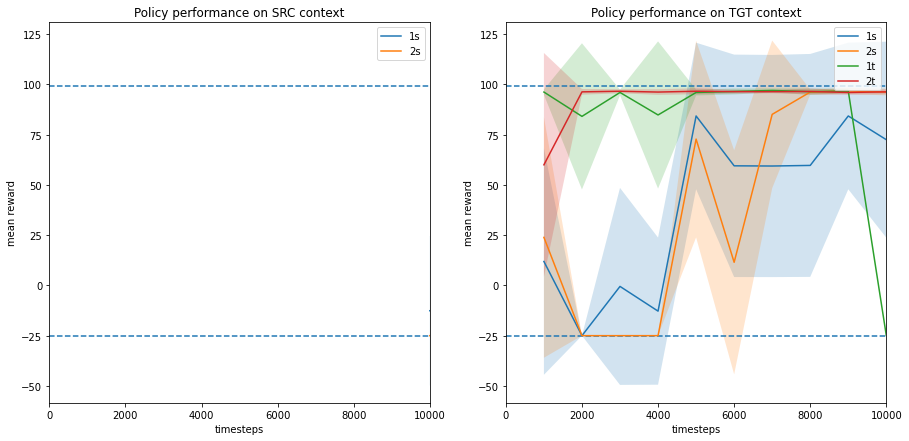

In [16]:
p = 'experiment_dumps'



pltr = Plotter(p, cfg_constraints=[{'env': SupportedEnvironments.SMALL,
                                    'mods': [Mods.AS, Mods.RS, Mods.GECOUPT]},
                                   {'env': SupportedEnvironments.SMALL,
                                    'mods': [Mods.AS, Mods.RS]}],
               u_bound=99, l_bound=-25, with_std=True, xlim=(0, 10e3))

src, tgt = ExperimentsRunner.load_or_sample_contexts(pltr.experiments[0], 10, 1, 24)


pltr.plot_compare_individual_seed(src, tgt)
# pltr.plot_compare_agg_seeds(src, tgt)

In [37]:
env = pltr.experiments[0].get_single_env_for_context_set(src)

In [71]:
env.reset()
env.render()

+-------+
| : | :P|
| : : : |
| : | | |
| | | : |
+-------+
Taxi0-YELLOW: Fuel: inf, Location: (0, 3), Engine: ON, Collided: False, Step: 0/25, ALIVE
Passenger0-YELLOW: Location: (0, 3), Destination: (-1, -1)
Env done: False

